In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [2]:
class DataCloud:
	N=0
	def __init__(self,x):
		self.n=1
		self.mean=x
		self.variance=0
		self.pertinency=1
		DataCloud.N+=1
	def addDataClaud(self,x):
		self.n=2
		self.mean=(self.mean+x)/2
		self.variance=((np.linalg.norm(self.mean-x))**2)
	def updateDataCloud(self,n,mean,variance):
		self.n=n
		self.mean=mean
		self.variance=variance

In [3]:
class AutoCloud:
	c= np.array([DataCloud(0)],dtype=DataCloud)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		AutoCloud.m = m
		AutoCloud.c= np.array([DataCloud(0)],dtype=DataCloud)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.classIndex = []
		AutoCloud.k = 1		

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#atualizando lista de data clouds 
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#Remover linhas 
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;   
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1
				
	def run(self,X):
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(AutoCloud.k-2)
				data.eccAn = eccentricity
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection.itemset(i,1)
				else:
					AutoCloud.alfa[i] = 0
					AutoCloud.listIntersection.itemset(i,0)
				i+=1
			
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0)) 
			self.mergeClouds()
			AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			classIndex = np.argmax(AutoCloud.relevanceList)
			AutoCloud.classIndex.append(classIndex)

        
		AutoCloud.k=AutoCloud.k+1


##S1

In [4]:
centroides_s1 = pd.read_csv('centroides_s1.csv')
c_s1 = np.array([centroides_s1["1"],centroides_s1["2"]])

In [5]:
data = pd.read_csv('s1.csv')
dados = np.array([data["1"],data["2"]])

In [6]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


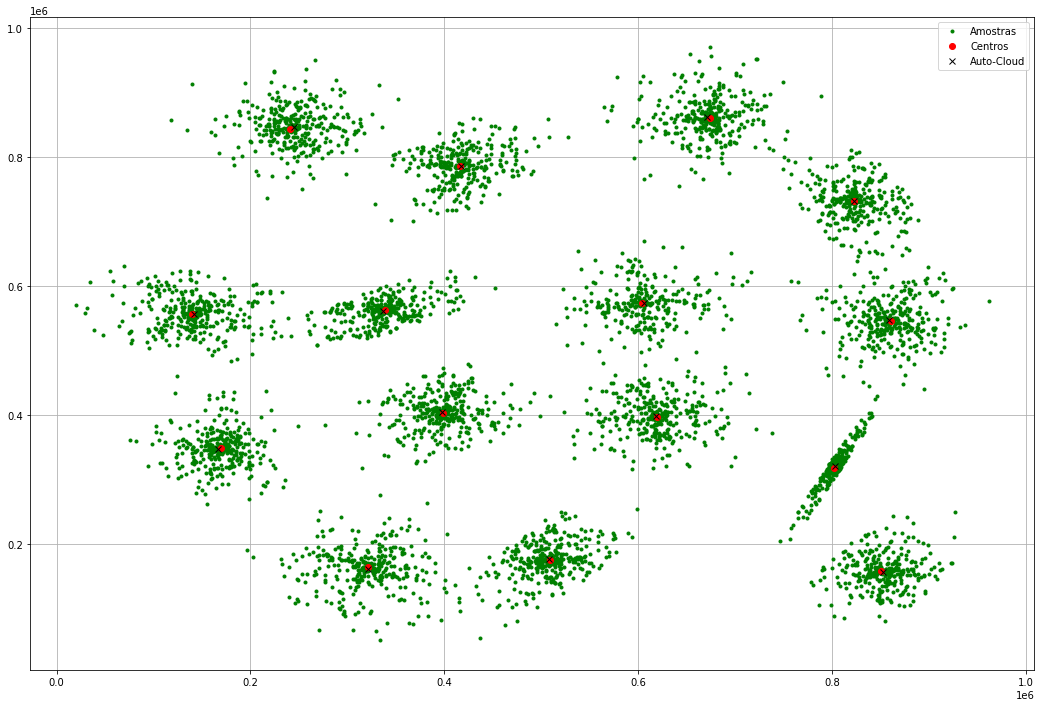

In [7]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_s1[0],c_s1[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()

##S2


In [8]:
centroides_s2 = pd.read_csv('centroides_s2.csv')
c_s2 = np.array([centroides_s2["1"],centroides_s2["2"]])

In [9]:
data = pd.read_csv('s2.csv')
dados = np.array([data["1"],data["2"]])

In [10]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


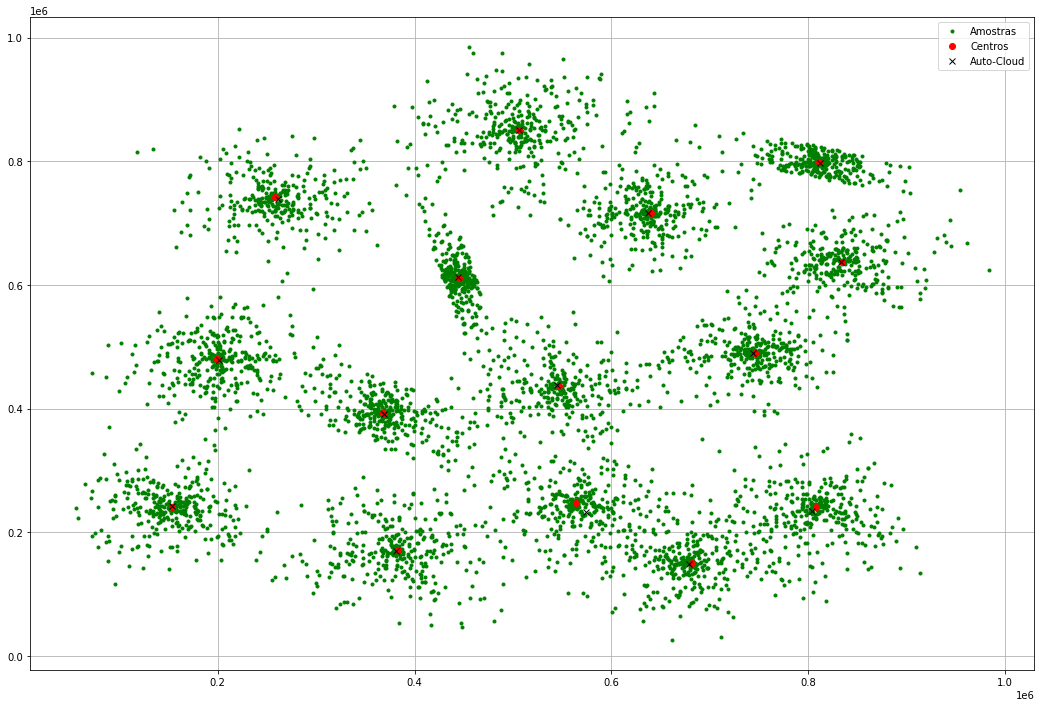

In [11]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_s2[0],c_s2[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()

##A1

In [12]:
centroides_a1 = pd.read_csv('centroides_a1.csv')
c_a1 = np.array([centroides_a1["1"],centroides_a1["2"]])

In [13]:
data = pd.read_csv('a1.csv')
dados = np.array([data["1"],data["2"]])

In [14]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


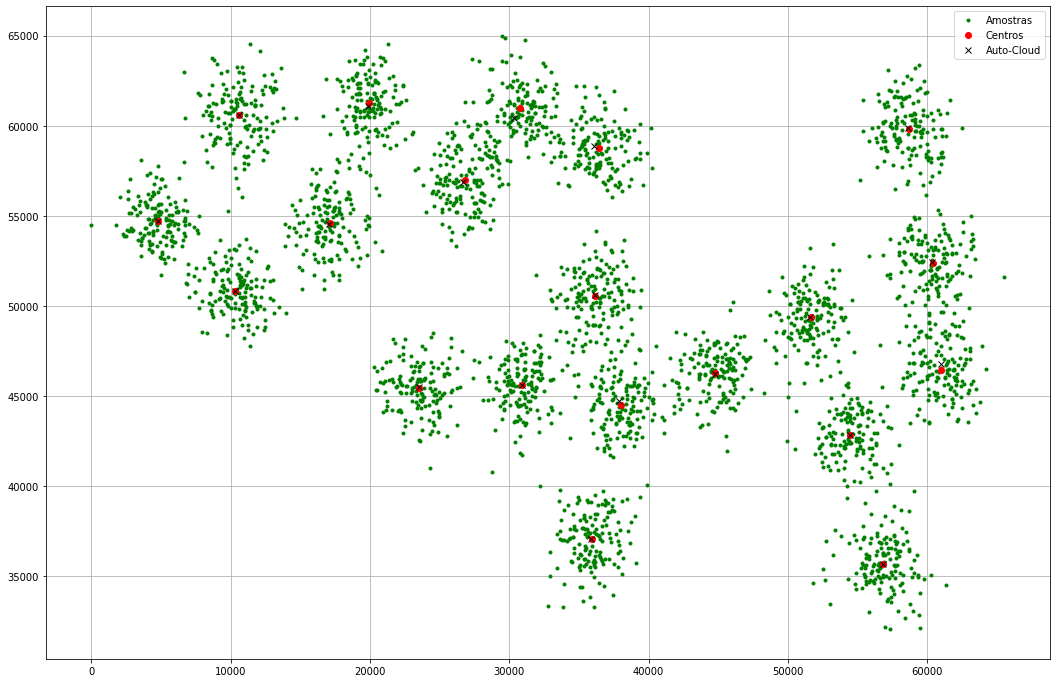

In [15]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_a1[0],c_a1[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()

##A2

In [16]:
centroides_a2 = pd.read_csv('centroides_a2.csv')
c_a2 = np.array([centroides_a2["1"],centroides_a2["2"]])

In [17]:
data = pd.read_csv('a2.csv')
dados = np.array([data["1"],data["2"]])

In [18]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


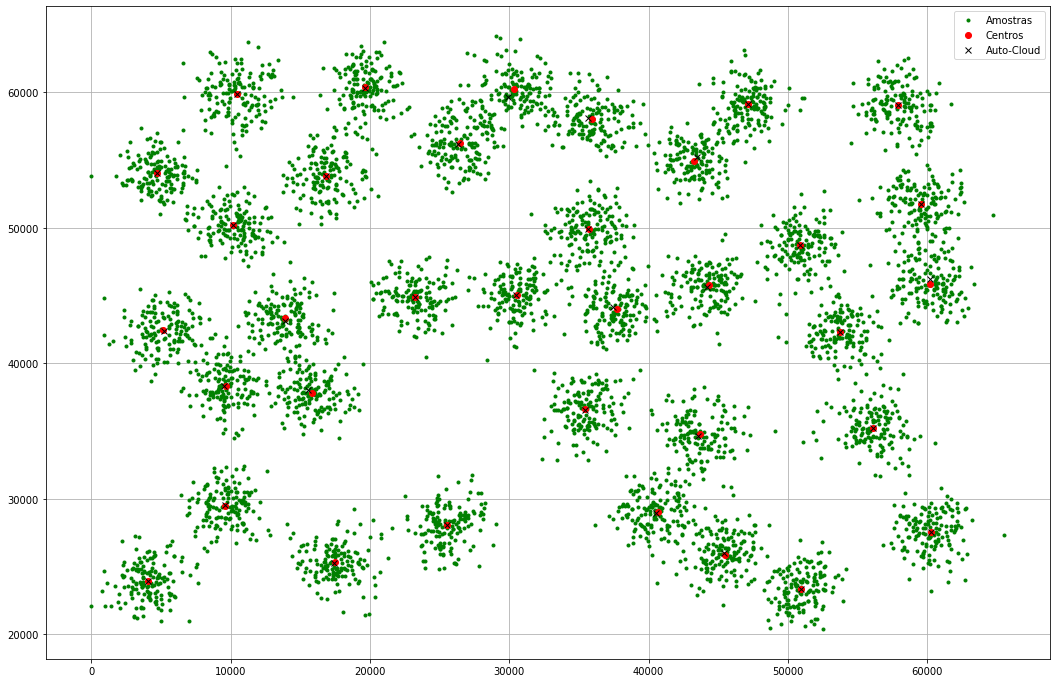

In [19]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_a2[0],c_a2[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()

##Compound

In [20]:
centroides_c = pd.read_csv('centrosCompound.csv')
c_c = np.array([centroides_c["1"],centroides_c["2"]])

In [21]:
data = pd.read_csv('Compound.csv')
dados = np.array([data["1"],data["2"]])

In [22]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


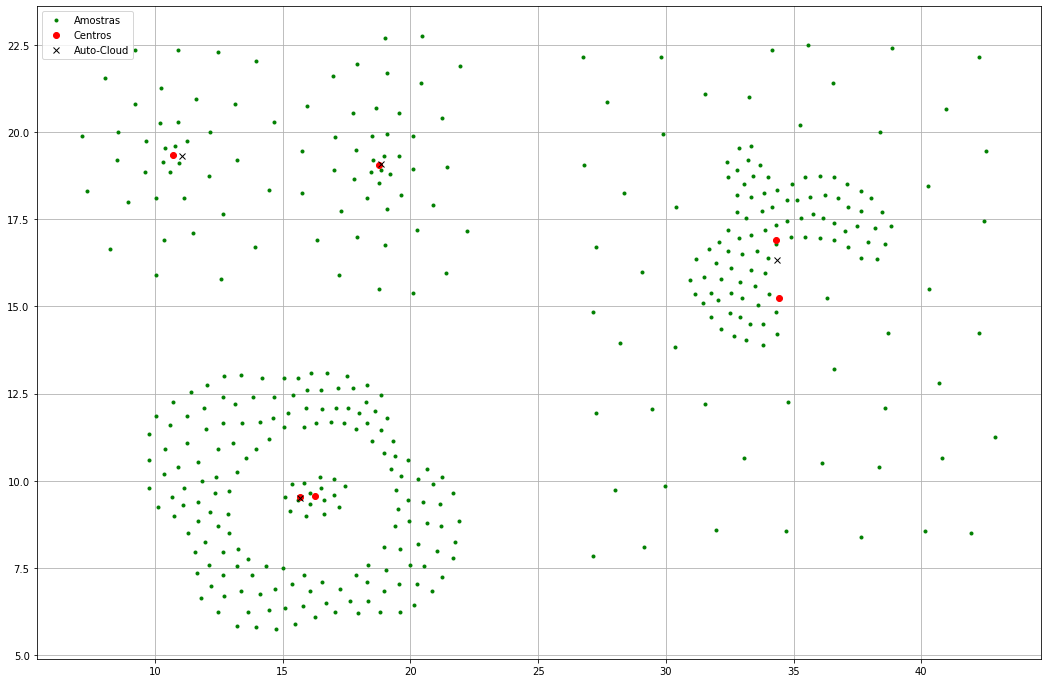

In [23]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_c[0],c_c[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()

##Unbalance

In [24]:
centroides_u = pd.read_csv('unbalance_centros.csv')
c_u = np.array([centroides_u["1"],centroides_u["2"]])

In [25]:
data = pd.read_csv('Unbalance.csv')
dados = np.array([data["1"],data["2"]])

In [26]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


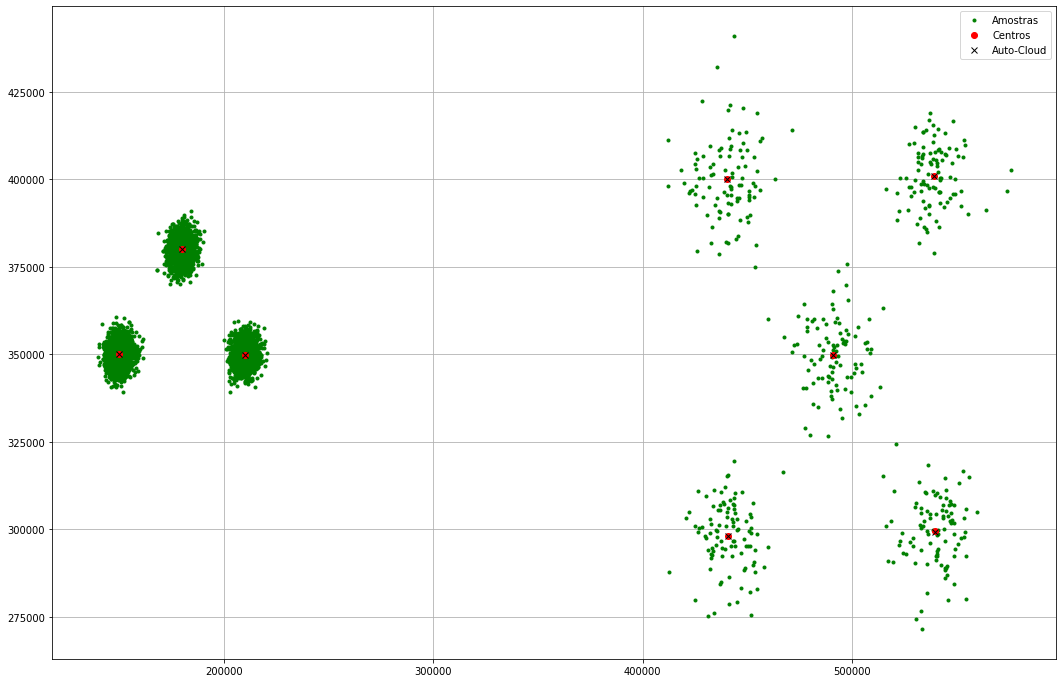

In [27]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_u[0],c_u[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()

##Aggregation

In [28]:
centroides_a = pd.read_csv('Aggregation_centros.csv')
c_a = np.array([centroides_a["1"],centroides_a["2"]])

In [29]:
data = pd.read_csv('Aggregation.csv')
dados = np.array([data["1"],data["2"]])

In [30]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


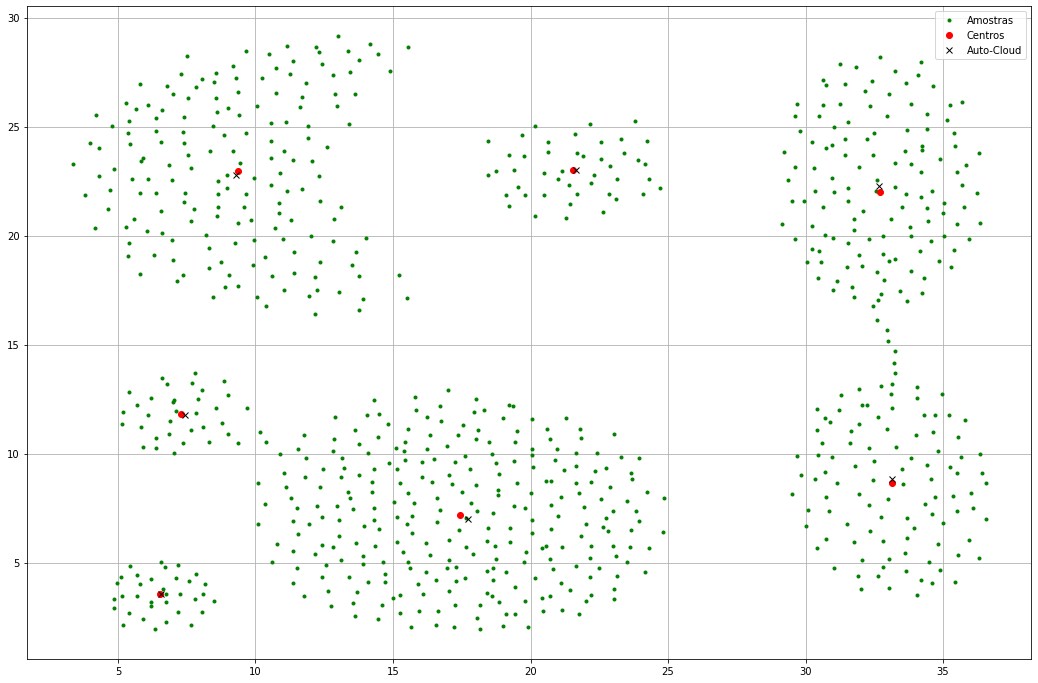

In [31]:
plt.rcParams["figure.figsize"] = (18,12)
plt.grid()
dados= dados.T
plt.plot(dados[0],dados[1],'.g')
plt.plot(c_a[0],c_a[1],'or')
for i in range(0,np.size(teste.c)):
    plt.plot(teste.c[i].mean[0],teste.c[i].mean[1],'x',color='black')
plt.legend(['Amostras','Centros','Auto-Cloud'])    
plt.show()